In [2]:
# some imports
import os
from functools import reduce
import operator
from skimage.draw import polygon
from scipy import interpolate
import numpy as np
np.random.seed(seed=1)
from glob import glob
%matplotlib notebook
from matplotlib import pyplot as plt
from natsort import natsorted
import keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# import custom functions and viewing tools
from VisTools import multi_slice_viewer0, mask_viewer0
from KerasModel import BlockModel, dice_coef_loss

In [20]:
#~# some parameters to set for training #~#
# path to save best model weights
model_version = 3
model_weights_path = os.path.join(os.getcwd(),
                                  'BestModelWeights_dataset2_v{:02d}.h5'.format(model_version))
# set number of unique subjects to be used for testing
test_num = 15
# set number of unique subjects to to be used for validation
val_num = 10
# whether to use data augmentation or not
augment = True
# how many iterations of data to train on
numEp = 50
# augmentation factor
augFact = 2

# set data directories
dataset_dir = os.path.join('/home','bashirmllab','dataset2')
subdirs = ['opposed','SSFSE','t1nfs']
data_dirs = [os.path.join(dataset_dir,d+'_output') for d in subdirs]

In [4]:
# find unique subjects
all_groupings = []
all_grouped_inputs = []
all_grouped_targets = []
all_numScans = 0
all_numSubjs = 0
for cur_data_dir,cur_subdir in zip(data_dirs,subdirs):
    all_inputs = natsorted(glob(os.path.join(cur_data_dir,"input*.npy")))
    all_targets = natsorted(glob(os.path.join(cur_data_dir,"target*.npy")))
    stem_length = len(cur_subdir)+7
    stems = [f[:-stem_length] for f in all_inputs]
    unq_stems = np.unique(stems)
    # get number of unique subjects
    numSubjs = len(unq_stems)
    print('For {} directory:'.format(cur_subdir))
    print('{} total scans found'.format(len(all_inputs)))
    print('{} unique subjects'.format(numSubjs))
    # group repeated scans together
    groupings = [[i for i, e in enumerate(stems) if e == u] for u in unq_stems]
    grouped_inputs = [[all_inputs[g] for g in group] for group in groupings]
    grouped_targets = [[all_targets[g] for g in group] for group in groupings]
    # add to cumulative lists
    all_groupings += groupings
    all_grouped_inputs += grouped_inputs
    all_grouped_targets += grouped_targets
    all_numScans += len(all_inputs)
    all_numSubjs += numSubjs
print('----------------------------------')
print('{} total scans found'.format(all_numScans))
print('{} total unique subjects found'.format(all_numSubjs))

For opposed directory:
47 total scans found
38 unique subjects
For SSFSE directory:
132 total scans found
54 unique subjects
For t1nfs directory:
80 total scans found
42 unique subjects
----------------------------------
259 total scans found
134 total unique subjects found


In [5]:
# Randaomly select test subject indices
# numpy is seeded so this is repeatable
tv_inds = np.random.choice(all_numSubjs,test_num+val_num,replace=False)
test_inds = tv_inds[:test_num]
val_inds = tv_inds[test_num:]

Note: if you need to rerun this following cell, run cells above this one first.

The code in this cell changes the input/target file lists so those lists need to be remade first before running this cell again.

In [6]:
# split into test,train,validation
# grab testing files and reduce to a single list
input_files_test = reduce(operator.add,[all_grouped_inputs[i] for i in test_inds])
target_files_test = reduce(operator.add,[all_grouped_targets[i] for i in test_inds])
# grab validation files and reduce to a single list
input_files_val = reduce(operator.add,[all_grouped_inputs[i] for i in val_inds])
target_files_val = reduce(operator.add,[all_grouped_targets[i] for i in val_inds])
# take the rest of the groups that aren't validation or test and bring together into
# single lists of inputs and targets
train_input_groups = [f for i,f in enumerate(all_grouped_inputs) if i not in tv_inds]
train_target_groups = [f for i,f in enumerate(all_grouped_targets) if i not in tv_inds]
input_files_train = reduce(operator.add,train_input_groups)
target_files_train = reduce(operator.add,train_target_groups)

In [7]:
# load input data
print('Loading input data...')
inputs_test = np.concatenate([np.load(f) for f in input_files_test])
inputs_val = np.concatenate([np.load(f) for f in input_files_val])
inputs_train = np.concatenate([np.load(f) for f in input_files_train])
# add singleton dimension for grayscale channel
testX = inputs_test[...,np.newaxis]
valX = inputs_val[...,np.newaxis]
trainX = inputs_train[...,np.newaxis]
print('Input data loaded')
print('{} training slices'.format(trainX.shape[0]))
print('{} validation slices'.format(valX.shape[0]))
print('{} testing slices'.format(testX.shape[0]))

Loading input data...
Input data loaded
8163 training slices
655 validation slices
1014 testing slices


In [8]:
# load target data
print('Loading target data...')
targets_test = np.concatenate([np.load(f) for f in target_files_test])
targets_val = np.concatenate([np.load(f) for f in target_files_val])
targets_train = np.concatenate([np.load(f) for f in target_files_train])
# add singleton dimension for grayscale channel
testY = targets_test[...,np.newaxis]
valY = targets_val[...,np.newaxis]
trainY = targets_train[...,np.newaxis]
print('Target data loaded')

Loading target data...
Target data loaded


In [9]:
# make model
model = BlockModel(trainX.shape,filt_num=16,numBlocks=4)
model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss)

In [10]:
# setup image data generator
if augment:
    datagen1 = ImageDataGenerator(
        rotation_range=10,
        shear_range=0.5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
    datagen2 = ImageDataGenerator(
        rotation_range=10,
        shear_range=0.5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
else:
    datagen1 = ImageDataGenerator()
    datagen2 = ImageDataGenerator()
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
datagen1.fit(trainX, seed=seed)
datagen2.fit(trainY, seed=seed)
batchsize = 32
datagen = zip( datagen1.flow( trainX, None, batchsize, seed=seed), datagen2.flow( trainY, None, batchsize, seed=seed) )

# calculate number of batches
if augment:
    steps = np.int(trainX.shape[0]/batchsize*augFact)
else:
    steps = np.int(trainX.shape[0]/batchsize)

In [21]:
# make callback for checkpointing
cb_check = ModelCheckpoint(model_weights_path,monitor='val_loss',
                                   verbose=0,save_best_only=True,
                                   save_weights_only=True,mode='auto',period=1)

In [ ]:
# train model
history = model.fit_generator(datagen,
                    steps_per_epoch=steps,
                    epochs=numEp,
                    callbacks=[cb_check],
                    verbose=1,
                    validation_data=(valX,valY))

Epoch 1/50
510/510 [==============================] - 504s 989ms/step - loss: 0.0713 - val_loss: 0.0953
Epoch 2/50
510/510 [==============================] - 493s 968ms/step - loss: 0.0679 - val_loss: 0.1364
Epoch 3/50
510/510 [==============================] - 495s 970ms/step - loss: 0.0672 - val_loss: 0.0729
Epoch 4/50
510/510 [==============================] - 496s 973ms/step - loss: 0.0657 - val_loss: 0.1076
Epoch 5/50
510/510 [==============================] - 496s 972ms/step - loss: 0.0654 - val_loss: 0.0819
Epoch 6/50
510/510 [==============================] - 497s 975ms/step - loss: 0.0669 - val_loss: 0.0859
Epoch 7/50
510/510 [==============================] - 493s 966ms/step - loss: 0.0708 - val_loss: 0.0979
Epoch 8/50
510/510 [==============================] - 498s 977ms/step - loss: 0.0643 - val_loss: 0.0950
Epoch 9/50
510/510 [==============================] - 499s 978ms/step - loss: 0.0666 - val_loss: 0.0873
Epoch 10/50
510/510 [==============================] - 498s 977m

<IPython.core.display.Javascript object>


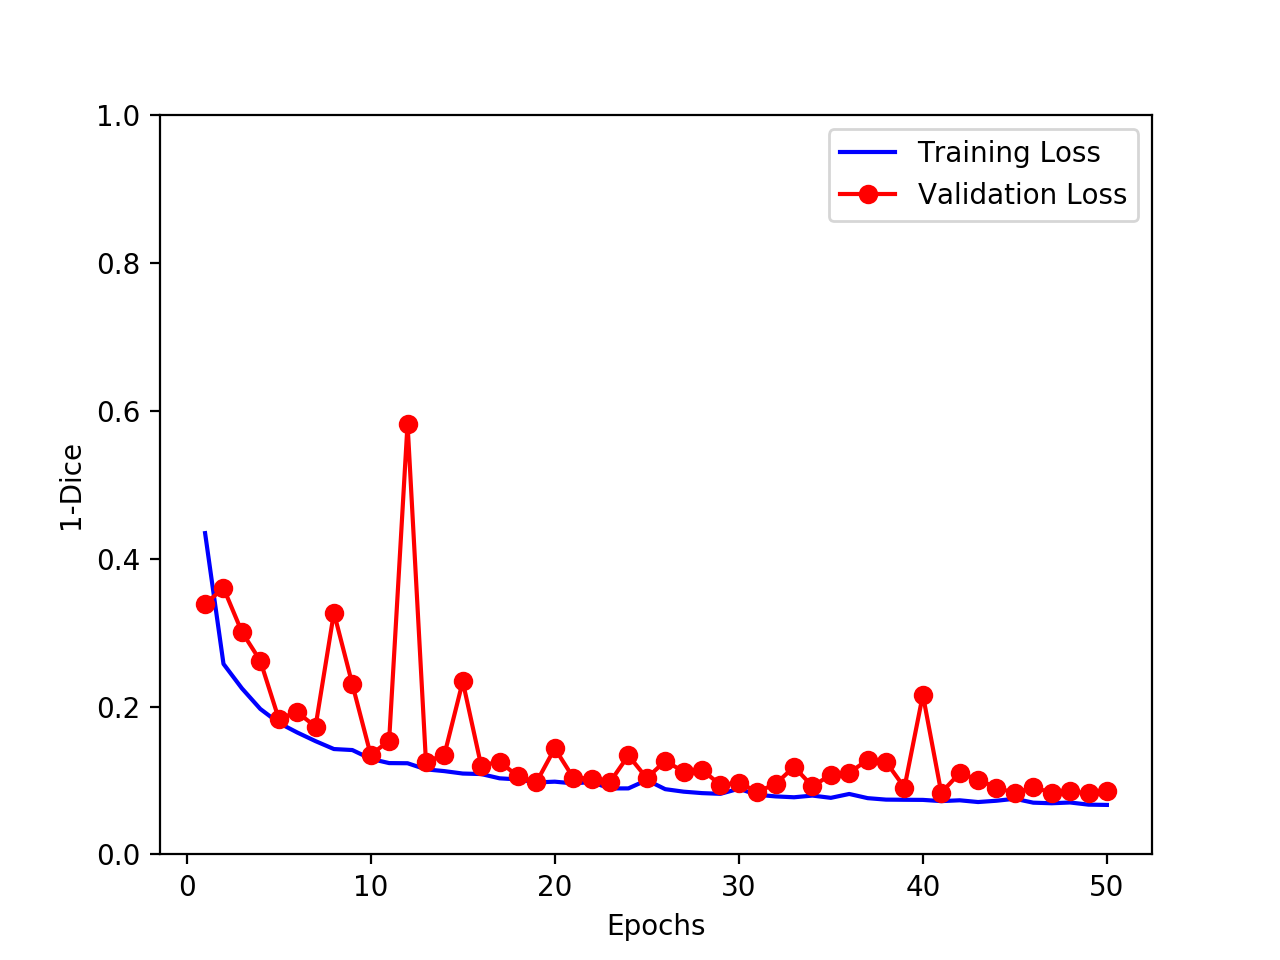

In [16]:
# Plot loss curves
epochs = np.arange(1,len(history.history['loss'])+1)
plt.figure()
plt.plot(epochs,history.history['loss'],'b-')
plt.plot(epochs,history.history['val_loss'],'r-o')
plt.xlabel('Epochs')
plt.ylabel('1-Dice')
plt.ylim([0,1])
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [14]:
# load best weights
model.load_weights(model_weights_path)
# evaluate on test data
score = model.evaluate(testX,testY,verbose=0)
print("Test Dice score is {:.03f}".format(1-score))

Test Dice score is 0.908


<IPython.core.display.Javascript object>


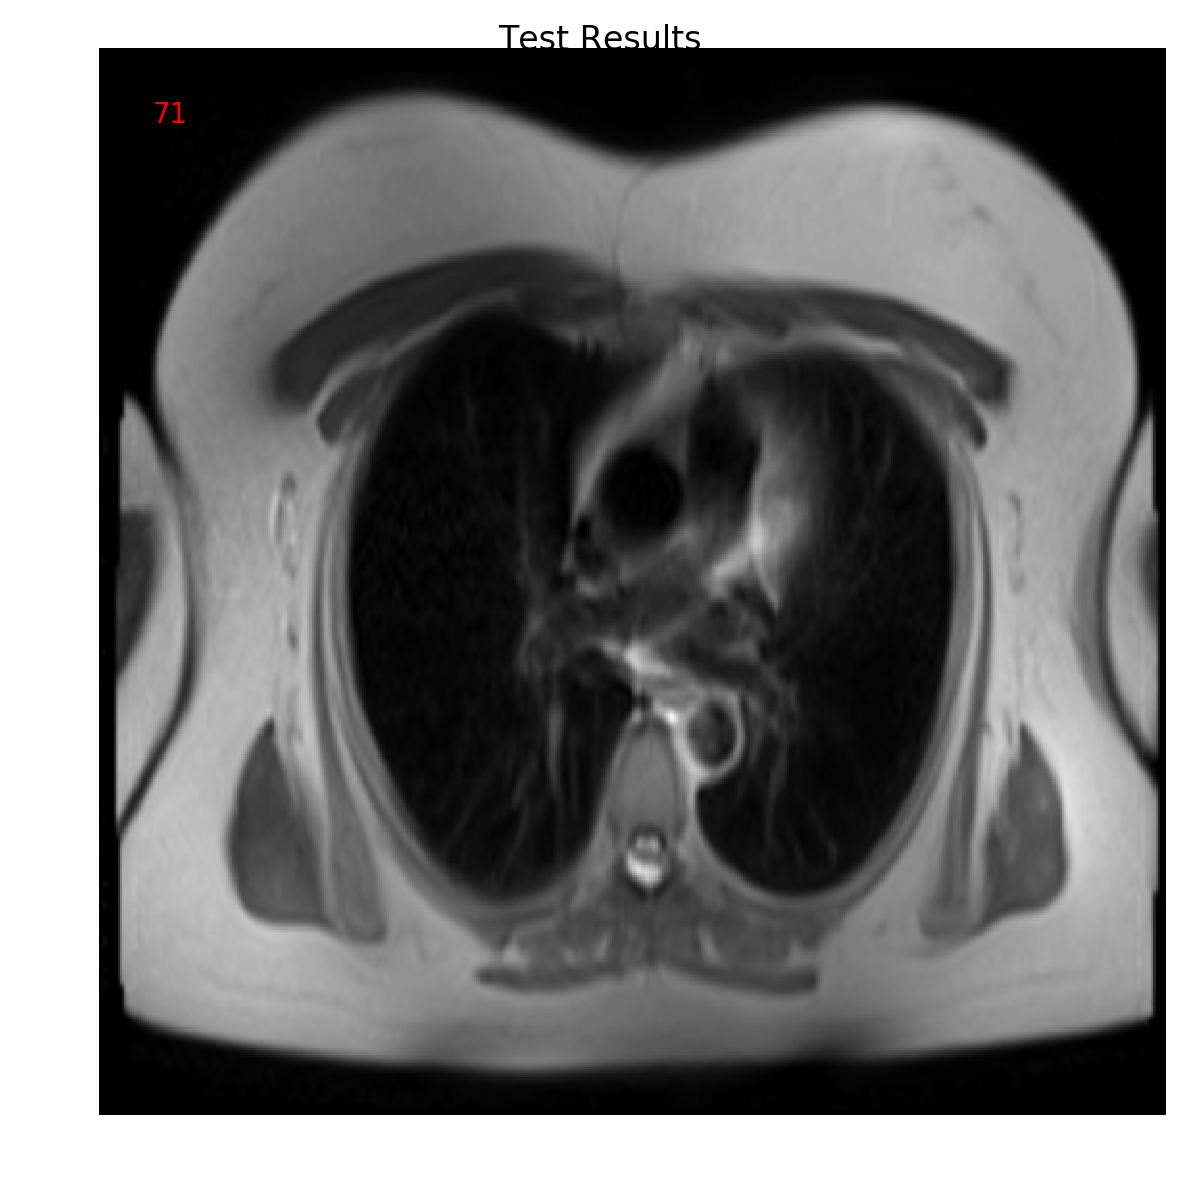

In [19]:
# display some results
output = model.predict(testX,batch_size=16)
mask_viewer0(testX[::4,...,0],testY[::4,...,0],output[::4,...,0],name='Test Results')
plt.show()

This set of cells can be run independently to get predicted volumes

In [ ]:
import os
from KerasModel import CalcVolumes
from natsort import natsorted
from glob import glob
# set data directory
data_dir = os.path.join('/home','johnsonj118','output')
# set voxel dimensions (in cm)
sx = .7
sy = .1
sz = .2
vox_vol = sx*sy*sz
# select which model to load
model_version = 4
# test file indices- copy and paste from
# cell 5 output
test_inds = [9, 10, 11, 35, 36, 37, 19, 20, 21]
# get input/target files
input_files= natsorted(glob(os.path.join(data_dir, "input*.npy")))
target_files= natsorted(glob(os.path.join(data_dir, "target*.npy")))
test_input_files = [input_files[i] for i in test_inds]
test_target_files = [target_files[i] for i in test_inds]
# create model
from KerasModel import BlockModel
model = BlockModel((1,512,512,1),filt_num=16,numBlocks=4)
# load saved weights
model_weights_path = os.path.join(os.getcwd(),'BestModelWeights_v{:02d}.h5'.format(model_version))
model.load_weights(model_weights_path)

In [ ]:
# choose subject to calculate volume of
subj_ind = 3
# run function to perform calculations
calc,truth = CalcVolumes(input_files[subj_ind],target_files[subj_ind],vox_vol,model)
# display result
print("The calculated volume is {:.02f} cm^3".format(calc))
print("The actual volume is {:.02f} cm^3".format(truth))

In [ ]:
# Get all volumes and plot correlation plot
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
results = [CalcVolumes(inp,targ,vox_vol,model) for inp,targ in zip(test_input_files,test_target_files)]

In [ ]:
x = [r[1] for r in results]
y = [r[0] for r in results]
plt.figure()
plt.plot(x,y,'ro')
plt.plot(np.arange(0,np.max(x)),np.arange(0,np.max(x)),'k--')
plt.xlim([0,np.max(x)])
plt.ylim([0,np.max(y)])
plt.ylabel('Calculated Volume (cc)')
plt.xlabel('Actual Volume (cc)')
plt.title("Correlation of Actual and Predicted Liver Volumes of Test Subjects")
plt.show()
cc = np.corrcoef(x,y)[0,1]
print('Correlation coefficient is {:.03f}'.format(cc))